# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

Homework9: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kos261/ML25/blob/main/Lab9/HW9.ipynb)


"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.


### Loading data

In [1]:
import torch
import torchvision
from matplotlib import pyplot



transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

### Model

In [2]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first 
            torch.nn.Linear(1024, 2048),
            torch.nn.Linear(2048,256),
            torch.nn.Linear(256,10),
        )

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

### Training model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(8):

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device) 
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)

        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") 

        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       
        optimizer.step()     
                        

/home/konstanty/Projects/UW/UWvenv/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Working on cpu
epoch: 0 batch: 0 current batch loss: 2.314847707748413
epoch: 0 batch: 1 current batch loss: 1.4185233116149902
epoch: 0 batch: 2 current batch loss: 1.1034132242202759
epoch: 0 batch: 3 current batch loss: 0.9320228695869446
epoch: 0 batch: 4 current batch loss: 0.7452142834663391
epoch: 0 batch: 5 current batch loss: 0.7683136463165283
epoch: 0 batch: 6 current batch loss: 0.6941710710525513
epoch: 0 batch: 7 current batch loss: 0.6621201634407043
epoch: 0 batch: 8 current batch loss: 0.6744024157524109
epoch: 0 batch: 9 current batch loss: 0.6486213803291321
epoch: 0 batch: 10 current batch loss: 0.616554856300354
epoch: 0 batch: 11 current batch loss: 0.5517517328262329
epoch: 0 batch: 12 current batch loss: 0.5504335165023804
epoch: 0 batch: 13 current batch loss: 0.5318702459335327
epoch: 0 batch: 14 current batch loss: 0.4694173336029053
epoch: 0 batch: 15 current batch loss: 0.4920271933078766
epoch: 0 batch: 16 current batch loss: 0.4219381511211395
epoch: 0 ba

In [4]:
net.eval()
good = 0
wrong = 0

with torch.no_grad():  
    for batch, data in enumerate(testloader):
        datapoint, label = data

        prediction = net(datapoint.to(device))                 
        classification = torch.argmax(prediction)    

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9132


### Now we have model that we can use for "dreaming"

In [8]:
import matplotlib.pyplot as plt

def dreaming(lambda_l2=0, multiple_digits=False):
    imgs = torch.randn(10, 1, 28, 28, requires_grad=True)
    # print(imgs[0][0].data)        
    # plt.imshow(imgs[0][0].detach())   # Uncomment to see noise
    # plt.show()

    for_animation = []
    imgs = imgs.to(device).clone().detach().requires_grad_()

    targets = torch.arange(10).to(device)

    net.eval()
    optimizer = torch.optim.Adam([imgs], lr=0.05)

    combinations = [
        [0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,0] #This is for "merged" numbers
    ]

    for step in range(1000):
        optimizer.zero_grad()

        batch_outputs = (net(imgs)).to(device)


        if multiple_digits:
            loss = 0.0
            for i in range(10):
                logits = batch_outputs[i]
                log_probs = torch.nn.functional.log_softmax(logits, dim=0)
                target_log_probs = log_probs[combinations[i]]
                loss_i = -target_log_probs.mean()
                loss += loss_i

        else:
            loss1 = -torch.nn.functional.cross_entropy(batch_outputs, targets) 
            loss2 = lambda_l2 * imgs.pow(2).mean()
            loss = -loss1 + loss2

        loss.backward()
        optimizer.step()
        imgs.data.clamp_(-1.5, 1.5)

        for_animation.append(imgs.clone().detach())

        # if step % 100 == 0:
        #     print(f"Step {step}, Loss: {-loss.item():.4f}")


    with torch.no_grad():
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(imgs[i][0].detach().cpu())
            plt.title(f"Digit {i}")
            plt.axis("off")

        # fig.suptitle(f"Regularization $\\lambda$ = {lambda_l2}")
        plt.tight_layout()
        plt.show()

    return for_animation

In [14]:
import matplotlib.animation as animation


def create_gif(for_animation, filename="Dreaming.gif"):
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    ims = []  # lista 10 obrazków

    for i in range(10):
        row, col = divmod(i, 5)
        ax = axs[row][col]
        ax.axis("off")
        ax.set_title(f"Digit {i}")
        
        # Załóżmy: for_animation[frame][digit][0][28x28]
        img = for_animation[0][i][0].detach().cpu()
        im = ax.imshow(img, animated=True)
        ims.append(im)

    def update(frame):
        for i in range(10):
            img = for_animation[frame][i][0].detach().cpu()
            ims[i].set_data(img)
        return ims

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=len(for_animation)-500,
        blit=True,
        repeat=True
    )

    ani.save(filename, writer='pillow', fps=240)
    plt.close(fig)


# Discussion

Created images doesn't resemble those from MNIST dataset. Reason might be that every layer in convolutional network "catches" characteristic shapes and structures in image. When NN gets image as an input it searches for those structures and with high probability decides which number it is, and doesn't care about noise. 
When we invert this process, NN generates images with noise, and structures that are parts of numbers. Then through train process, optimizer amplifies both noise and those structures. That's why we can see some patterns in those images but they don't look similar to those from MNIST.

Normal dreaming (no penalization)


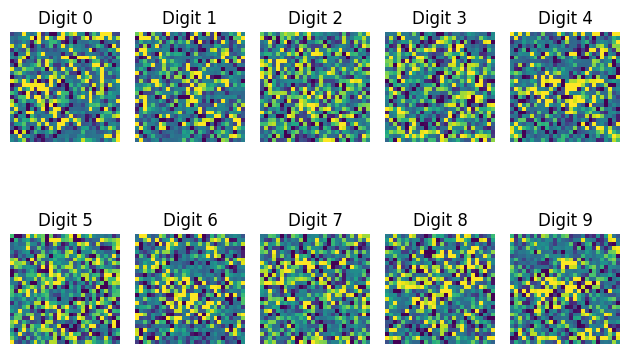

Dreaming "merged" digits


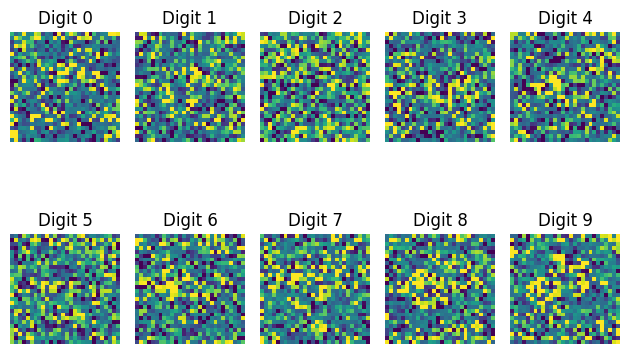

Dreaming with different penalization parameter lambda


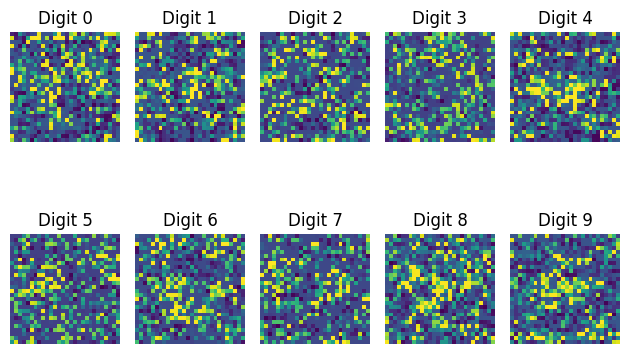

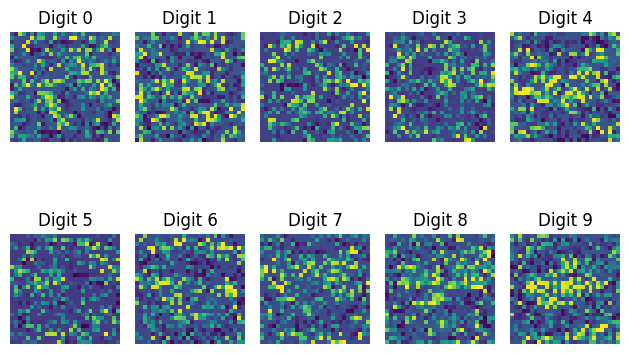

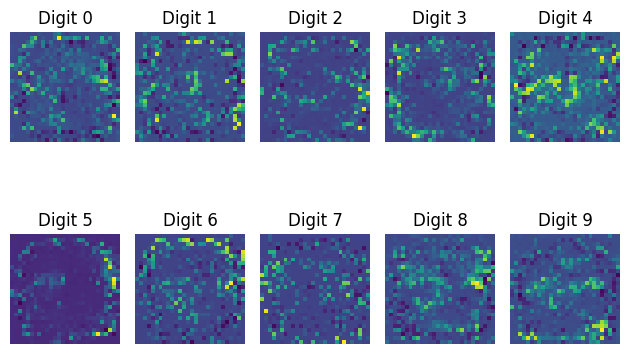

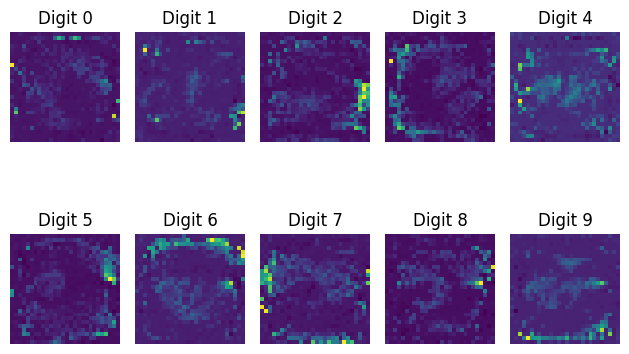

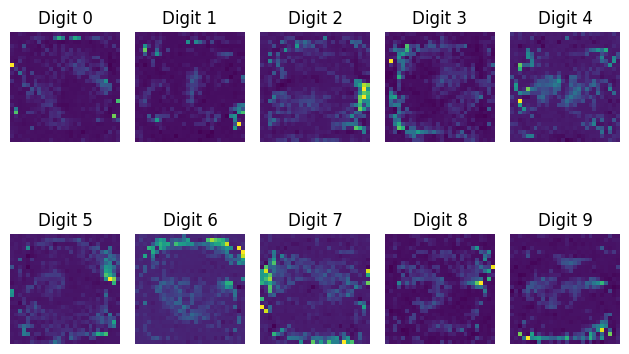

In [15]:
print("Normal dreaming (no penalization)")
for_animation = dreaming(lambda_l2=0)
create_gif(for_animation)        

print('Dreaming "merged" digits')
for_animation = dreaming(lambda_l2=10, multiple_digits=True)       


print("Dreaming with different penalization parameter lambda")
lambda_l2 = 0.001

for i in range(5):
    for_animation = dreaming(lambda_l2=lambda_l2 * (10 ** i))   #Penalization 
    # animation(for_animation)
create_gif(for_animation, "Dreaming_lbda_10.gif")